## Sentiment Analysis

In [1]:
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [3]:
classifier("this is a such a great movie")

[{'label': 'POSITIVE', 'score': 0.9998687505722046}]

In [4]:
classifier("I can't understand any of this")

[{'label': 'NEGATIVE', 'score': 0.9992030262947083}]

In [5]:
classifier(["great book, I like it", "this is terrible"])

[{'label': 'POSITIVE', 'score': 0.9998823404312134},
 {'label': 'NEGATIVE', 'score': 0.9996459484100342}]

In [6]:
filePath ="data/AirlineTweets.csv"
df_ = pd.read_csv(filePath)

In [7]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df = df_[['airline_sentiment', 'text']].copy()

<Axes: >

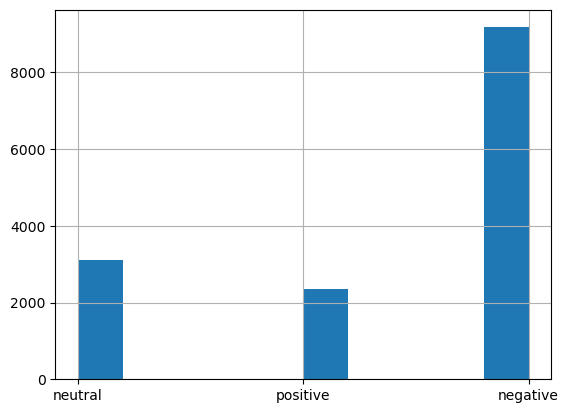

In [9]:
df['airline_sentiment'].hist()

In [10]:
df = df[df.airline_sentiment != 'neutral'].copy()

In [11]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [12]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [13]:
len(df)

11541

In [16]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [17]:
torch.cuda.current_device()

0

In [18]:
classifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [19]:
texts = df['text'].tolist()
predictions = classifier(texts)

In [20]:
predictions[:3]

[{'label': 'POSITIVE', 'score': 0.6070839166641235},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588}]

In [21]:
probs = [ d['score'] if d['label'].startswith('P') else 1 - d['score'] for d in predictions]

In [23]:
probs[:3]

[0.6070839166641235, 0.0026550889015197754, 0.0004176497459411621]

In [25]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]

In [26]:
preds = np.array(preds)

In [27]:
print("acc:", np.mean(df['target'] == preds))

acc: 0.8898708950697514


In [28]:
cm = confusion_matrix(df['target'], preds, normalize='true')
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

In [29]:
f1_score(df['target'], preds)

0.758777756690074

In [30]:
f1_score(1 -df['target'], 1 - preds)

0.928647616908999